<a href="https://colab.research.google.com/github/gachet/ad-1-24/blob/main/Analyse_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Load modules**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.signal import find_peaks
from scipy.stats import iqr, skew, kurtosis
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split

**Plot data**

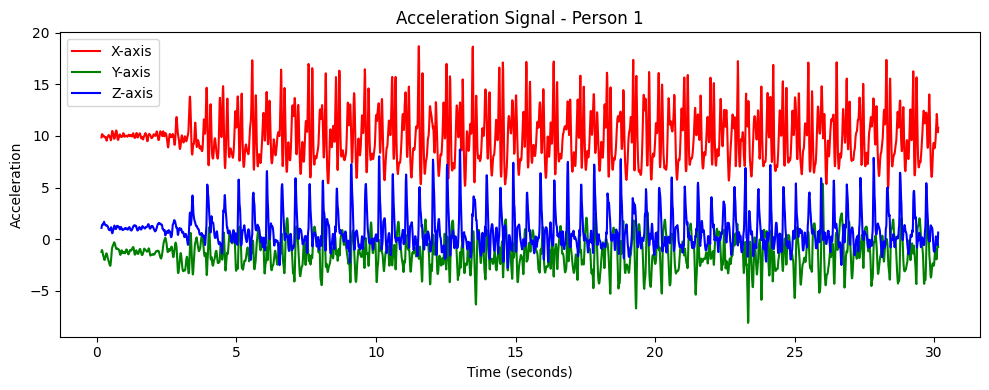

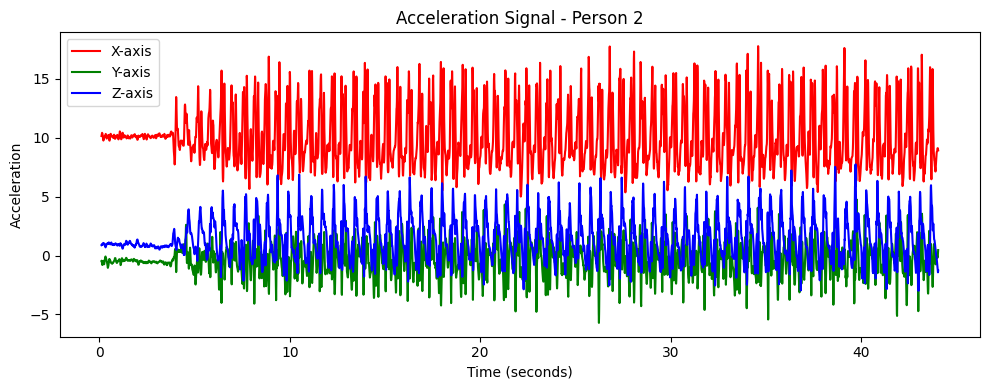

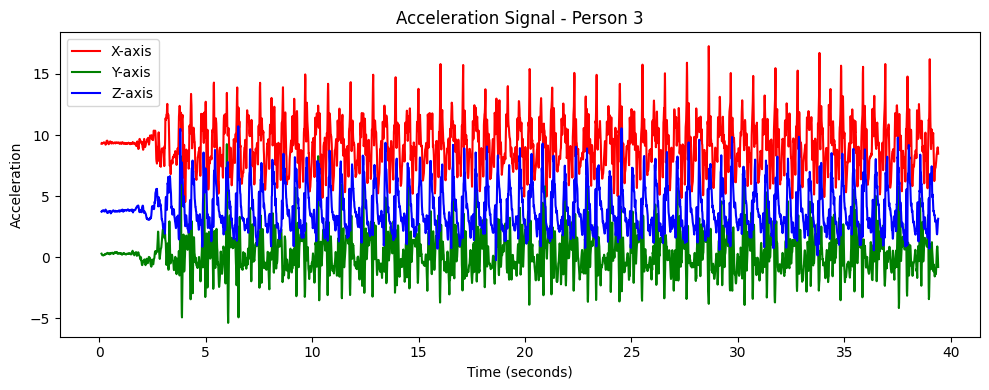

In [ ]:
file_paths = ['acc1.csv', 'acc2.csv', 'acc3.csv']
person_labels = ['Person 1', 'Person 2', 'Person 3']

for file, label in zip(file_paths, person_labels):
    data = pd.read_csv(file)
    time = data['seconds_elapsed']
    x = data['x']
    y = data['y']
    z = data['z']

    plt.figure(figsize=(10, 4))
    plt.plot(time, x, label='X-axis', color='r')
    plt.plot(time, y, label='Y-axis', color='g')
    plt.plot(time, z, label='Z-axis', color='b')
    plt.title(f'Acceleration Signal - {label}')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Acceleration')
    plt.legend()
    plt.tight_layout()
    plt.show()

**Select only the vertical (X) axis and only the central part of the signals**

In [ ]:
signals = []

for file in file_paths:
    data = pd.read_csv(file, delimiter=',')

    start_time = 5 #####################
    end_time = start_time + 25 ##########
    print(start_time,end_time)

    # Filter the data for the central 30 seconds
    filtered_data = data[(data['seconds_elapsed'] >= start_time) & (data['seconds_elapsed'] <= end_time)]

    # Extract the X component
    signals.append(filtered_data['x'].values)

# Truncate all signals to the same length (minimum length across all signals)
min_length = min(len(signal) for signal in signals)
signals = np.array([signal[:min_length] for signal in signals]).T  # Create nx3 matrix

# Print the resulting matrix
print("Signals Matrix (nx3):")
print(signals)


5 30
5 30
5 30
Signals Matrix (nx3):
[[11.20573807  8.91693306 12.72561932]
 [12.02496433  9.29301071 12.29804039]
 [12.88970375  9.64154148 10.42962837]
 ...
 [ 9.15767097  9.99725819  8.31089687]
 [ 9.32774448 10.04636383  7.96595907]
 [ 9.25708008 10.00683975  7.87613201]]


**Plot**

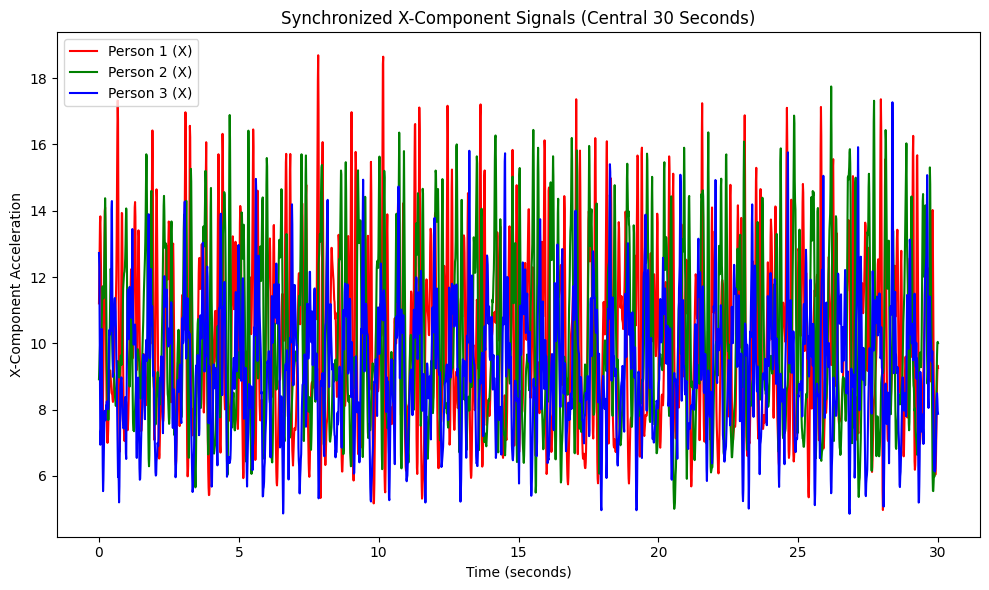

In [ ]:
time = np.linspace(0, 30, signals.shape[0])

plt.figure(figsize=(10, 6))
plt.plot(time, signals[:, 0], label='Person 1 (X)', color='r')
plt.plot(time, signals[:, 1], label='Person 2 (X)', color='g')
plt.plot(time, signals[:, 2], label='Person 3 (X)', color='b')

plt.title('Synchronized X-Component Signals (Central 30 Seconds)')
plt.xlabel('Time (seconds)')
plt.ylabel('X-Component Acceleration')
plt.legend()
plt.tight_layout()
plt.show()

**Calculate auto-correlation**

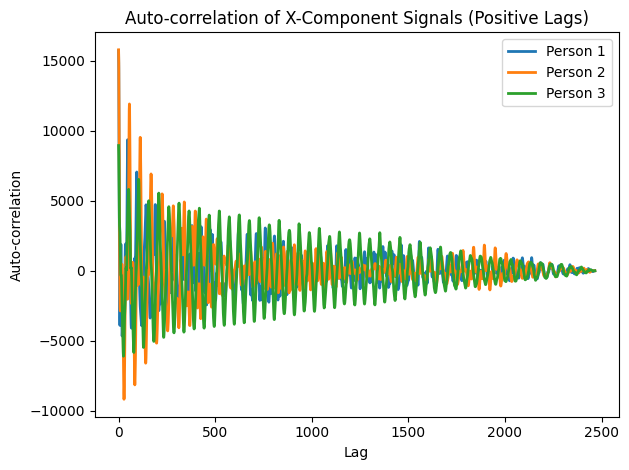

In [ ]:
auto_correlations = []

for i in range(signals.shape[1]):
    signal = signals[:, i]-np.mean(signals[:,i],axis=0)
    auto_corr = np.correlate(signal, signal, mode='full')
    auto_corr = auto_corr[auto_corr.size // 2:]
    auto_correlations.append(auto_corr)
    plt.plot(auto_corr, label=f'Person {i+1}', linewidth=2)

plt.title('Auto-correlation of X-Component Signals (Positive Lags)')
plt.xlabel('Lag')
plt.ylabel('Auto-correlation')
plt.legend()
plt.tight_layout()
plt.show()


Person 1 - First two peaks (lag, auto-correlation):
Lag: 47, Auto-correlation: 0.5952659693954885
Lag: 94, Auto-correlation: 0.4485829400081659

Person 1 - Extracted Features:
Step Time: 0.47 s
Stride Time: 0.94 s
Step Regularity: 0.60
Stride Regularity: 0.45
Asymmetry: 0.25

Person 2 - First two peaks (lag, auto-correlation):
Lag: 56, Auto-correlation: 0.7549222054546206
Lag: 112, Auto-correlation: 0.6038327092036199

Person 2 - Extracted Features:
Step Time: 0.56 s
Stride Time: 1.12 s
Step Regularity: 0.75
Stride Regularity: 0.60
Asymmetry: 0.20

Person 3 - First two peaks (lag, auto-correlation):
Lag: 52, Auto-correlation: 0.6502274095374405
Lag: 104, Auto-correlation: 0.7298741874286193

Person 3 - Extracted Features:
Step Time: 0.52 s
Stride Time: 1.04 s
Step Regularity: 0.65
Stride Regularity: 0.73
Asymmetry: -0.12



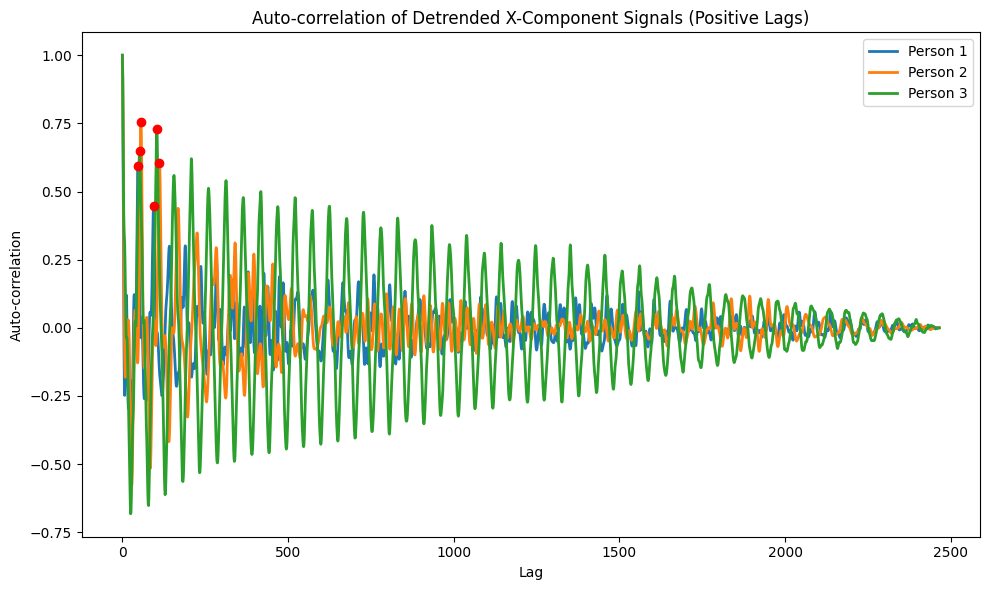

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Remove the mean from each signal
signals_detrended = signals - np.mean(signals, axis=0)

# Compute and plot auto-correlation for each detrended signal
plt.figure(figsize=(10, 6))

features = []

for i in range(signals_detrended.shape[1]):  # Iterate over each column (signal)
    signal = signals_detrended[:, i]
    auto_corr = np.correlate(signal, signal, mode='full')  # Full mode gives the full auto-correlation
    auto_corr = auto_corr[auto_corr.size // 2:]  # Keep only the non-negative lags (positive part)
    auto_corr = auto_corr/auto_corr[0] # Normalize

    # Find peaks in the auto-correlation
    peaks, _ = find_peaks(auto_corr,prominence=0.1, distance=40)  # Find the indices of the peaks

    # Get the first two peaks
    first_two_peaks = peaks[:2]

    # Plot the auto-correlation
    plt.plot(auto_corr, label=f'Person {i+1}', linewidth=2)

    # Plot the first two peaks
    plt.scatter(first_two_peaks, auto_corr[first_two_peaks], color='red', zorder=5)

    # Print the x and y coordinates of the first two peaks
    print(f"Person {i+1} - First two peaks (lag, auto-correlation):")
    for peak in first_two_peaks:
        print(f"Lag: {peak}, Auto-correlation: {auto_corr[peak]}")
    print()

    step_time = first_two_peaks[0] / 100  # Step time (x-coordinate of the first peak divided by 100)
    stride_time = first_two_peaks[1] / 100  # Stride time (x-coordinate of the second peak divided by 100)
    step_regularity = auto_corr[first_two_peaks[0]]  # Step regularity (y-coordinate of the first peak)
    stride_regularity = auto_corr[first_two_peaks[1]]  # Stride regularity (y-coordinate of the second peak)
    asymmetry = (auto_corr[first_two_peaks[0]] - auto_corr[first_two_peaks[1]]) / auto_corr[first_two_peaks[0]]  # Asymmetry

    features.append({
        'person': i+1,
        'step_time': step_time,
        'stride_time': stride_time,
        'step_regularity': step_regularity,
        'stride_regularity': stride_regularity,
        'asymmetry': asymmetry
    })

    # Print the features for this person
    print(f"Person {i+1} - Extracted Features:")
    print(f"Step Time: {step_time:.2f} s")
    print(f"Stride Time: {stride_time:.2f} s")
    print(f"Step Regularity: {step_regularity:.2f}")
    print(f"Stride Regularity: {stride_regularity:.2f}")
    print(f"Asymmetry: {asymmetry:.2f}")
    print()

# Customize the plot
plt.title('Auto-correlation of Detrended X-Component Signals (Positive Lags)')
plt.xlabel('Lag')
plt.ylabel('Auto-correlation')
plt.legend()
plt.tight_layout()
plt.show()


**Radar plot for comparison**

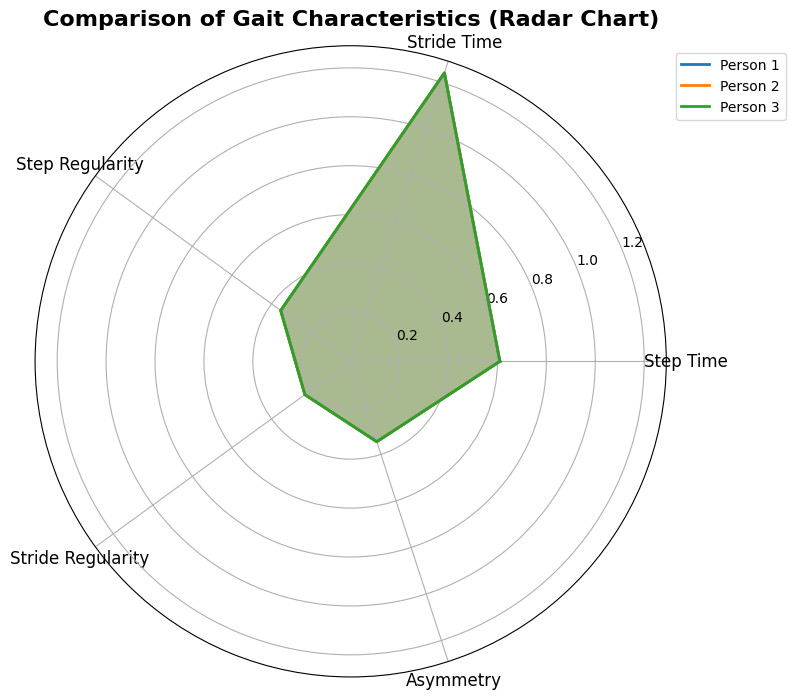

In [ ]:
features_df = pd.DataFrame(features)

labels = ['Step Time', 'Stride Time', 'Step Regularity', 'Stride Regularity', 'Asymmetry']
num_subjects = len(features_df)
num_features = len(labels)
values = features_df[['step_time', 'stride_time', 'step_regularity', 'stride_regularity', 'asymmetry']].values

angles = np.linspace(0, 2 * np.pi, num_features, endpoint=False).tolist()

values = np.concatenate((values, values[:, [0]]), axis=1)
angles += angles[:1]


plt.figure(figsize=(8, 8))

for i in range(num_subjects):
    plt.polar(angles, values[i], linewidth=2, label=f'Person {i+1}')
    plt.fill(angles, values[i], alpha=0.25)

plt.xticks(angles[:-1], labels, color='black', size=12)
plt.title('Comparison of Gait Characteristics (Radar Chart)', size=16, color='black', weight='bold')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.tight_layout()
plt.show()


**Perform classification and evaluate performance**

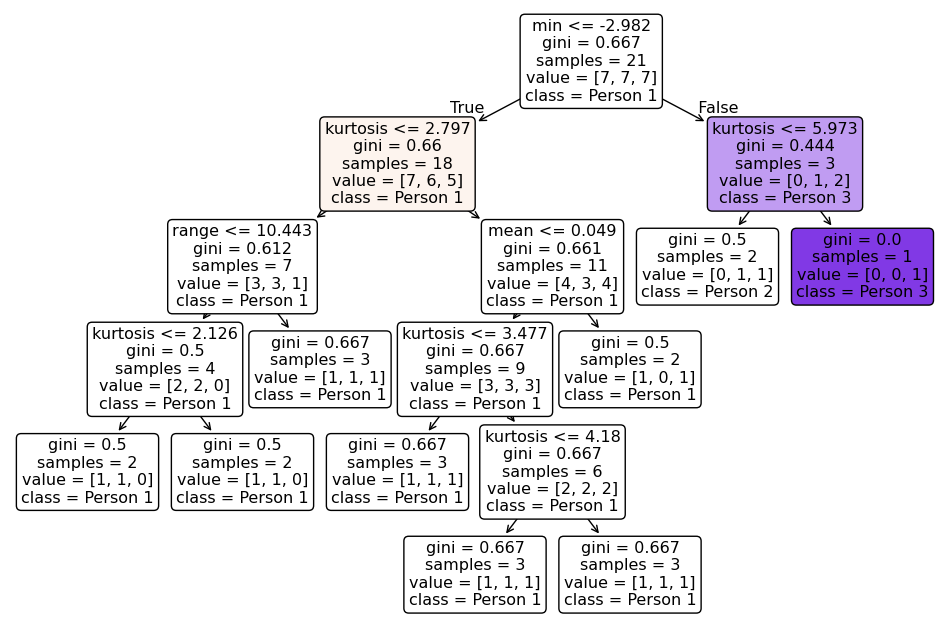

Feature Importances:
min: 0.3889
kurtosis: 0.3319
range: 0.1429
mean: 0.1364
skewness: 0.0000
iqr: 0.0000
max: 0.0000
std: 0.0000


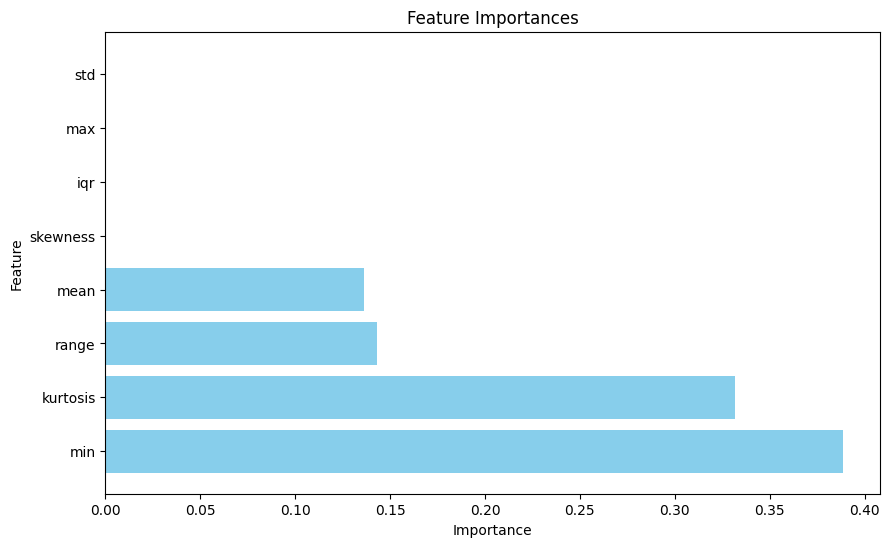

Train accuracy: 42.86%
Test accuracy: 0.00%


In [ ]:
def segment_signal(signal, fs=100, window_size=2):
    window_samples = fs * window_size  # Number of samples per window
    segments = [signal[i:i + window_samples] for i in range(0, len(signal), window_samples) if i + window_samples <= len(signal)]
    return np.array(segments)

def extract_basic_features(segment):
    features = {
        'mean': np.mean(segment),
        'std': np.std(segment),
        'range': np.max(segment) - np.min(segment),
        'min': np.min(segment),
        'max': np.max(segment),
        'iqr': iqr(segment),
        'skewness': skew(segment),
        'kurtosis': kurtosis(segment),
    }
    return features

fs = 100
window_size = 2

all_segments = []
all_features = []
labels = []

for i in range(3):  # For each subject
    segments = segment_signal(signals_detrended[:, i], fs=fs, window_size=window_size)
    for segment in segments:
        features = extract_basic_features(segment)
        all_features.append(list(features.values()))
        labels.append(i)

features_df = pd.DataFrame(all_features, columns=['mean', 'std', 'range', 'min', 'max', 'iqr', 'skewness', 'kurtosis'])
labels = np.array(labels)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features_df, labels, test_size=0.2, stratify=labels)

# Train the decision tree classifier
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

# Plot the decision tree
plt.figure(figsize=(12, 8))
plot_tree(clf, filled=True, feature_names=features_df.columns, class_names=['Person 1', 'Person 2', 'Person 3'], rounded=True)
plt.show()

# Assess the most important features for classification
feature_importances = clf.feature_importances_
sorted_idx = np.argsort(feature_importances)[::-1]
important_features = features_df.columns[sorted_idx][:5]

print("Feature Importances:")
for feature, importance in zip(features_df.columns[sorted_idx], feature_importances[sorted_idx]):
    print(f"{feature}: {importance:.4f}")

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(features_df.columns[sorted_idx], feature_importances[sorted_idx], color='skyblue')
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Evaluate classifier performance
train_accuracy = clf.score(X_train, y_train)
test_accuracy = clf.score(X_test, y_test)

print(f"Train accuracy: {train_accuracy * 100:.2f}%")
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

